<a href="https://colab.research.google.com/github/langsari/price-prediction-model/blob/main/price_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**STEP 1 : Import Libraries**



In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

#**STEP 2 : Load Data (SET Index)**

In [24]:
ticker = "^SET.BK"
data = yf.download(ticker, start="2020-01-01", progress=False)
data = data.dropna()
print("✅ Data Loaded:", data.shape)
data.tail()

/tmp/ipython-input-46898481.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2020-01-01", progress=False)


✅ Data Loaded: (1393, 5)


Price,Close,High,Low,Open,Volume
Ticker,^SET.BK,^SET.BK,^SET.BK,^SET.BK,^SET.BK
Date,,,,,
2025-10-01,1275.030029,1280.810059,1271.780029,1272.459961,3466200
2025-10-02,1288.290039,1294.140015,1282.949951,1284.750000,3201300
2025-10-03,1293.609985,1300.050049,1286.270020,1290.329956,3463700
2025-10-06,1285.640015,1299.239990,1285.640015,1296.290039,3225600
2025-10-07,1305.239990,1310.680054,1291.900024,1293.680054,0


# **STEP 3 : Add Technical Indicators**

In [25]:
df = data.copy()

# EMA (Exponential Moving Average)
df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()

# RSI (Relative Strength Index)
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rs = gain / loss
df['RSI14'] = 100 - (100 / (1 + rs))

# MACD (Moving Average Convergence Divergence)
df['MACD'] = df['EMA12'] - df['EMA26']
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Volume Moving Average
df['Vol_MA20'] = df['Volume'].rolling(20).mean()

# Simple support and resistance levels
df['Support'] = df['Low'].rolling(window=20).min()
df['Resistance'] = df['High'].rolling(window=20).max()


df = df.dropna()

#**STEP 4 : Create Target (Next Day Close)**

In [26]:
df['target_price'] = df['Close'].shift(-1)
df = df.dropna()

#**STEP 5 : Prepare Features and Split Data**

In [27]:
features = ['Close','EMA12','EMA26','RSI14','MACD','MACD_signal','Vol_MA20','Support','Resistance']
X = df[features]
y = df['target_price']

split = int(len(X)*0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

#**STEP 6 : Train Model (Random Forest)**

In [28]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)
rmse = mean_squared_error(y_test, preds) ** 0.5
print(f"✅ Model trained | RMSE = {rmse:.4f}")

✅ Model trained | RMSE = 41.0173


#**STEP 7 : Visualization**

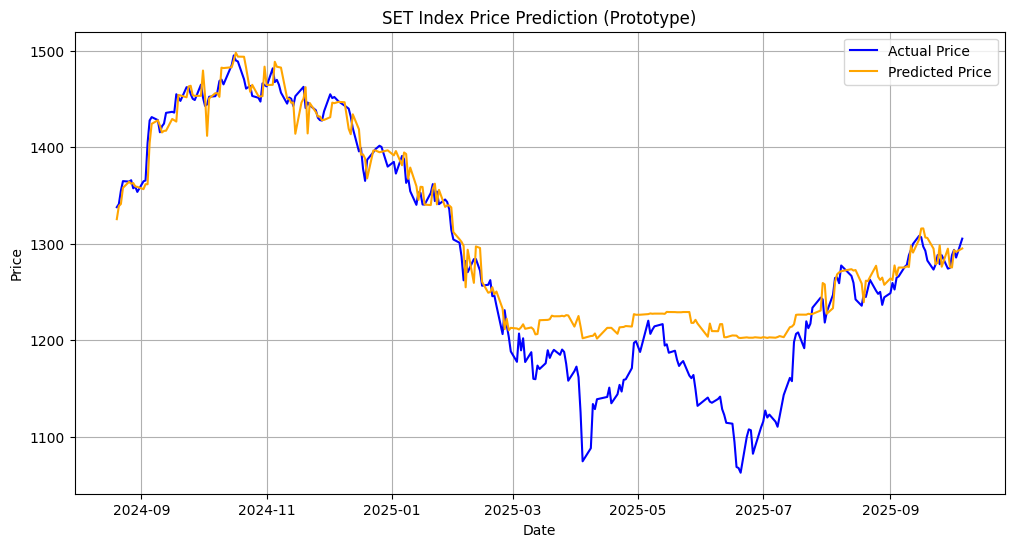

In [29]:
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test.values, label='Actual Price', color='blue')
plt.plot(y_test.index, preds, label='Predicted Price', color='orange')
plt.title("SET Index Price Prediction (Prototype)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

#**STEP 8 : Feature Importance**

In [30]:
importance = pd.Series(model.feature_importances_, index=features)
print("📊 Feature Importance:")
print(importance.sort_values(ascending=False))

📊 Feature Importance:
Close          0.977241
MACD           0.016240
MACD_signal    0.001345
Resistance     0.001192
Vol_MA20       0.001015
RSI14          0.000967
EMA12          0.000793
EMA26          0.000730
Support        0.000477
dtype: float64


In [31]:
df.head()

Price,Close,High,Low,Open,Volume,EMA12,EMA26,RSI14,MACD,MACD_signal,Vol_MA20,Support,Resistance,target_price
Ticker,^SET.BK,^SET.BK,^SET.BK,^SET.BK,^SET.BK,,,,,,,,,
Date,,,,,,,,,,,,,,
2020-01-29,1524.589966,1528.140015,1511.150024,1522.880005,3104100,1557.124349,1571.892666,29.002931,-14.768317,-7.660898,3553280.0,1507.359985,1604.430054,1523.989990
2020-01-30,1523.989990,1525.170044,1515.680054,1516.359985,2644100,1552.026755,1568.344320,28.332024,-16.317564,-9.392231,3513375.0,1507.359985,1604.430054,1514.140015
2020-01-31,1514.140015,1532.089966,1514.140015,1528.859985,2744300,1546.198026,1564.329186,23.329825,-18.131160,-11.140017,3488015.0,1507.359985,1604.280029,1496.060059
2020-02-03,1496.060059,1513.430054,1495.939941,1507.280029,2636200,1538.484492,1559.272213,20.188987,-20.787721,-13.069558,3414020.0,1495.939941,1604.280029,1519.380005
2020-02-04,1519.380005,1520.099976,1499.209961,1501.339966,3098100,1535.545340,1556.317235,31.843565,-20.771895,-14.610025,3408860.0,1495.939941,1604.280029,1534.140015


In [32]:
!pip install xgboost

In [33]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

In [34]:
from sklearn.metrics import mean_squared_error

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds) ** 0.5
    return rmse, preds

In [35]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
}

results = {}
for name, model in models.items():
    rmse, preds = evaluate_model(model, X_train, y_train, X_test, y_test)
    results[name] = rmse
    print(f"{name}: RMSE = {rmse:.2f}")

Linear Regression: RMSE = 13.12
Random Forest: RMSE = 41.02
XGBoost: RMSE = 53.38


In [36]:
print("\n📊 Model Comparison:")
for name, score in results.items():
    print(f"- {name}: RMSE = {score:.2f}")


📊 Model Comparison:
- Linear Regression: RMSE = 13.12
- Random Forest: RMSE = 41.02
- XGBoost: RMSE = 53.38


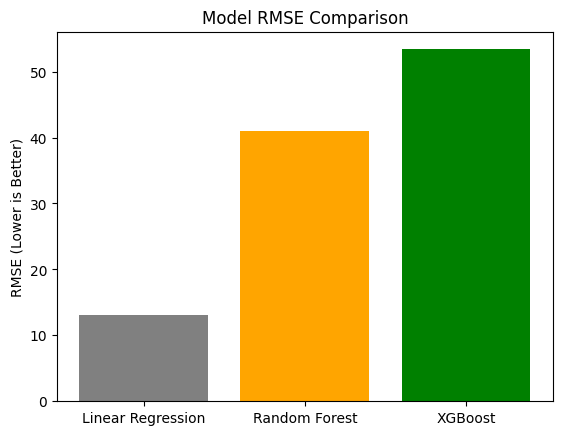

In [37]:
plt.bar(results.keys(), results.values(), color=['gray','orange','green'])
plt.title("Model RMSE Comparison")
plt.ylabel("RMSE (Lower is Better)")
plt.show()

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

**ฟังก์ชันประเมินโมเดล**

In [44]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    preds = pd.Series(model.predict(X_test), index=y_test.index)  # <-- ตรงนี้สำคัญ
    rmse = mean_squared_error(y_test, preds) ** 0.5
    return rmse, preds

**กำหนดโมเดลทั้งหมด**

In [45]:
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),  # ตัวที่หนูรันก่อนหน้า
    "Linear Regression": LinearRegression(),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
}

**เก็บผลลัพธ์**

In [46]:
results = []
predictions = {}

for name, model in models.items():
    rmse, preds = evaluate_model(model, X_train, y_train, X_test, y_test)
    results.append({"Model": name, "RMSE": rmse})
    predictions[name] = preds

**สร้าง DataFrame ตารางเปรียบเทียบ**

In [47]:
results_df = pd.DataFrame(results).sort_values(by="RMSE")
print("📊 Model Comparison Table:")
print(results_df)

📊 Model Comparison Table:
               Model       RMSE
1  Linear Regression  13.123818
0      Random Forest  41.017278
2            XGBoost  53.384393


**วาดกราฟเปรียบเทียบราคาจริงกับแต่ละโมเดล**

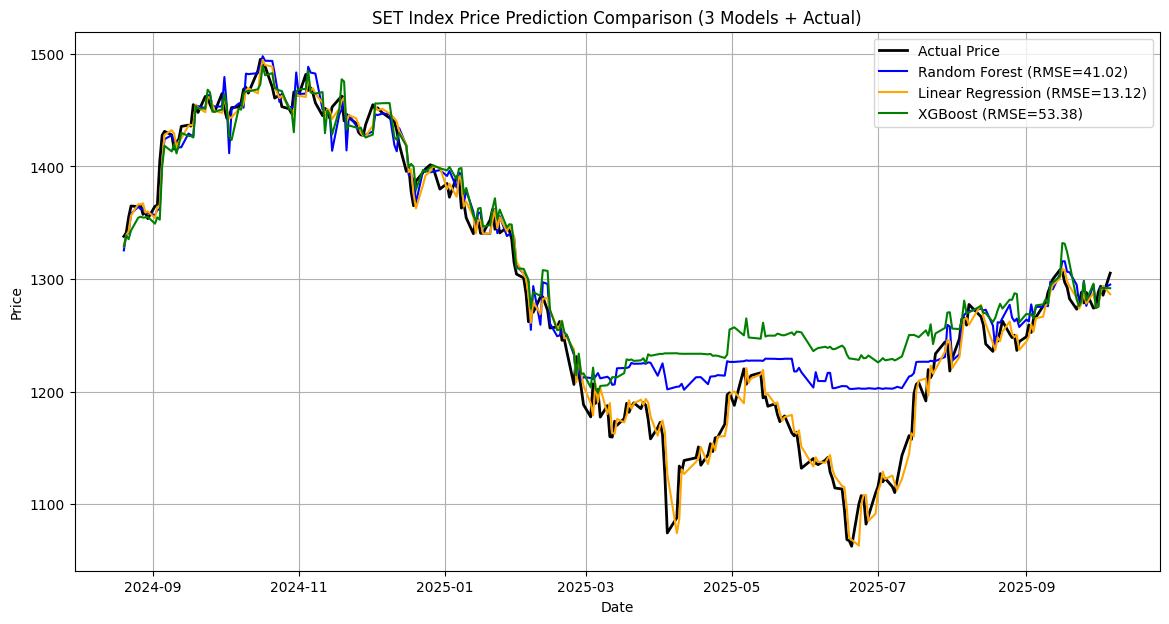

In [48]:
plt.figure(figsize=(14,7))
plt.plot(y_test.index, y_test.values, label='Actual Price', color='black', linewidth=2)

colors = ['blue', 'orange', 'green']
for i, (name, preds) in enumerate(predictions.items()):
    plt.plot(y_test.index, preds, label=f"{name} (RMSE={results_df.loc[results_df['Model']==name,'RMSE'].values[0]:.2f})", color=colors[i])

plt.title("SET Index Price Prediction Comparison (3 Models + Actual)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()